# Import Necessary Libraries
This cell imports all the necessary libraries required for data cleaning, including `pandas` for data manipulation, `numpy` for numerical operations, and `matplotlib` for plotting.

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent DataFrame output from wrapping to the next line
pd.options.display.float_format = '{:,.2f}'.format

# Load Data
Load the [Kaggle West Nile Virus Competition](https://www.kaggle.com/c/predict-west-nile-virus) dataset from CSV files into Pandas DataFrames. This includes loading both the training and testing datasets.

In [2]:
# Load the datasets
train = pd.read_csv('/app/data/train.csv')
test = pd.read_csv('/app/data/test.csv')
weather = pd.read_csv('/app/data/weather.csv')

# Reduce the length of the items in each column
train_summary = train.apply(lambda col: col.map(lambda x: (x[:13] + '...') if isinstance(x, str) and len(x) > 13 else x))
test_summary = test.apply(lambda col: col.map(lambda x: (x[:13] + '...') if isinstance(x, str) and len(x) > 13 else x))
weather_summary = weather.apply(lambda col: col.map(lambda x: (x[:13] + '...') if isinstance(x, str) and len(x) > 13 else x))

# Initial Data Inspection
Display the first few rows of the dataset to understand the structure and the type of data contained in the columns. This helps identify any immediate inconsistencies or cleaning requirements.

In [3]:
print("Train Data Summary:")
print(train_summary.head())

print("\nTest Data Summary:")
print(test_summary.head())

print("\nWeather Data Summary:")
print(weather_summary.head())

Train Data Summary:
         Date           Address           Species  Block            Street  Trap AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  NumMosquitos  WnvPresent
0  2007-05-29  4100 North Oa...  CULEX PIPIENS...     41   N OAK PARK A...  T002       4100  N OAK P...     41.95     -87.80                9             1           0
1  2007-05-29  4100 North Oa...  CULEX RESTUAN...     41   N OAK PARK A...  T002       4100  N OAK P...     41.95     -87.80                9             1           0
2  2007-05-29  6200 North Ma...  CULEX RESTUAN...     62   N MANDELL AV...  T007       6200  N MANDE...     41.99     -87.77                9             1           0
3  2007-05-29  7900 West Fos...  CULEX PIPIENS...     79      W FOSTER AVE  T015       7900  W FOSTE...     41.97     -87.82                8             1           0
4  2007-05-29  7900 West Fos...  CULEX RESTUAN...     79      W FOSTER AVE  T015       7900  W FOSTE...     41.97     -87.82                

# Check for Missing Values
Check each column for missing values to assess the extent of data imputation needed or to identify any patterns in the missing data.


In [21]:
# Make summary df to view null, stats and data type information along with the first row of the df
def generate_data_summary(df):
    # Create a DataFrame to hold information
    summary = pd.DataFrame()

    # Add dtype of each column
    summary['Dtype'] = df.dtypes

    # Add number of missing values per column
    summary['Missing Values'] = df.isnull().sum()

    # Add number of unique values per column
    summary['Unique Values'] = df.nunique()

    # Descriptive statistics
    stats = df.describe().transpose()  # This generates descriptive statistics
    summary = summary.join(stats[['count', 'mean', 'std', 'min', 'max']], how='outer')  # Join with the summary

    # Add first row to show sample data
    summary['First Row'] = df.iloc[0].apply(str)

    summary = summary.apply(lambda col: col.map(lambda x: (x[:13] + '...') if isinstance(x, str) and len(x) > 13 else x))

    return summary

train_summary = generate_data_summary(train)
test_summary = generate_data_summary(test)
weather_summary = generate_data_summary(weather)

In [22]:
print("Train Data Summary:")
print(train_summary)

Train Data Summary:
                          Dtype  Missing Values  Unique Values     count   mean   std    min    max         First Row
Address                  object               0            138       NaN    NaN   NaN    NaN    NaN  4100 North Oa...
AddressAccuracy           int64               0              4 10,506.00   7.82  1.45   3.00   9.00                 9
AddressNumberAndStreet   object               0            138       NaN    NaN   NaN    NaN    NaN  4100  N OAK P...
Block                     int64               0             64 10,506.00  35.69 24.34  10.00  98.00                41
Date                     object               0             95       NaN    NaN   NaN    NaN    NaN        2007-05-29
Latitude                float64               0            138 10,506.00  41.84  0.11  41.64  42.02          41.95469
Longitude               float64               0            138 10,506.00 -87.70  0.10 -87.93 -87.53        -87.800991
NumMosquitos              int64     

In [23]:
print("\nTest Data Summary:")
print(test_summary)


Test Data Summary:
                          Dtype  Missing Values  Unique Values      count      mean       std    min        max         First Row
Address                  object               0            151        NaN       NaN       NaN    NaN        NaN  4100 North Oa...
AddressAccuracy           int64               0              4 116,293.00      7.95      1.25   3.00       9.00                 9
AddressNumberAndStreet   object               0            151        NaN       NaN       NaN    NaN        NaN  4100  N OAK P...
Block                     int64               0             65 116,293.00     41.13     24.86  10.00      98.00                41
Date                     object               0             95        NaN       NaN       NaN    NaN        NaN        2008-06-11
Id                        int64               0         116293 116,293.00 58,147.00 33,571.04   1.00 116,293.00                 1
Latitude                float64               0            151 116,293

In [24]:
print("\nWeather Data Summary:")
print(weather_summary)


Weather Data Summary:
               Dtype  Missing Values  Unique Values    count  mean   std   min    max   First Row
AvgSpeed      object               0            178      NaN   NaN   NaN   NaN    NaN         9.2
CodeSum       object               0             98      NaN   NaN   NaN   NaN    NaN            
Cool          object               0             31      NaN   NaN   NaN   NaN    NaN           2
Date          object               0           1472      NaN   NaN   NaN   NaN    NaN  2007-05-01
Depart        object               0             42      NaN   NaN   NaN   NaN    NaN          14
Depth         object               0              2      NaN   NaN   NaN   NaN    NaN           0
DewPoint       int64               0             54 2,944.00 53.46 10.68 22.00  75.00          51
Heat          object               0             31      NaN   NaN   NaN   NaN    NaN           0
PrecipTotal   object               0            168      NaN   NaN   NaN   NaN    NaN        0.

# Checking if numeric columns contain non-numeric values

In [25]:
# Checking weather columns for non-numeric values
def check_non_numeric(df, column):
    # Temporarily converts values to numbers, marking non-convertibles as NaN
    temp = pd.to_numeric(df[column], errors='coerce')
    if temp.isna().any():
        # Identify rows where conversion failed
        non_numeric_rows = df[temp.isna()]
        return non_numeric_rows[column].unique()

print("Weather data Non-numeric values:")
weather_numeric_cols = ["Station","Tmax","Tmin","Tavg","Depart","DewPoint","WetBulb","Heat","Cool","Sunrise","Sunset","Depth","Water1","SnowFall","PrecipTotal","StnPressure","SeaLevel","ResultSpeed","ResultDir","AvgSpeed"]
for column in weather_numeric_cols:
    non_numeric_value = check_non_numeric(weather, column)
    if non_numeric_value is not None: print(f"{column} {non_numeric_value}")

Weather data Non-numeric values:
Tavg ['M']
Depart ['M']
WetBulb ['M']
Heat ['M']
Cool ['M']
Sunrise ['-']
Sunset ['-']
Depth ['M']
Water1 ['M']
SnowFall ['M' '  T']
PrecipTotal ['  T' 'M']
StnPressure ['M']
SeaLevel ['M']
AvgSpeed ['M']


In [26]:
print("Training data Non-numeric values:")
train_numeric_cols = ["Species","Block","Trap","Latitude","Longitude","AddressAccuracy","NumMosquitos","WnvPresent"]
for column in train_numeric_cols:
    non_numeric_value = check_non_numeric(train, column)
    if non_numeric_value is not None: print(f"{column} {non_numeric_value}")

Training data Non-numeric values:
Species ['CULEX PIPIENS/RESTUANS' 'CULEX RESTUANS' 'CULEX PIPIENS'
 'CULEX SALINARIUS' 'CULEX TERRITANS' 'CULEX TARSALIS' 'CULEX ERRATICUS']
Trap ['T002' 'T007' 'T015' 'T045' 'T046' 'T048' 'T049' 'T050' 'T054' 'T086'
 'T091' 'T094' 'T096' 'T129' 'T143' 'T148' 'T153' 'T159' 'T009' 'T011'
 'T016' 'T019' 'T025' 'T028' 'T031' 'T033' 'T089' 'T090' 'T092' 'T135'
 'T141' 'T142' 'T145' 'T146' 'T147' 'T149' 'T150' 'T151' 'T152' 'T154'
 'T158' 'T162' 'T218' 'T220' 'T001' 'T003' 'T006' 'T008' 'T012' 'T034'
 'T037' 'T040' 'T043' 'T047' 'T051' 'T085' 'T088' 'T161' 'T219' 'T013'
 'T014' 'T018' 'T030' 'T084' 'T144' 'T160' 'T005' 'T017' 'T044' 'T095'
 'T004' 'T035' 'T036' 'T039' 'T060' 'T061' 'T062' 'T065' 'T066' 'T067'
 'T069' 'T070' 'T071' 'T073' 'T074' 'T075' 'T076' 'T077' 'T079' 'T080'
 'T081' 'T082' 'T083' 'T114' 'T155' 'T063' 'T115' 'T138' 'T200' 'T206'
 'T209' 'T212' 'T215' 'T107' 'T128' 'T072' 'T078' 'T097' 'T099' 'T100'
 'T102' 'T103' 'T027' 'T156' 'T157' 'T2

# Clean Train and Test Data
Converting columns to the correct type, encoding catagorical data, adding new features (location clustering, rolling average and lagging time series data).

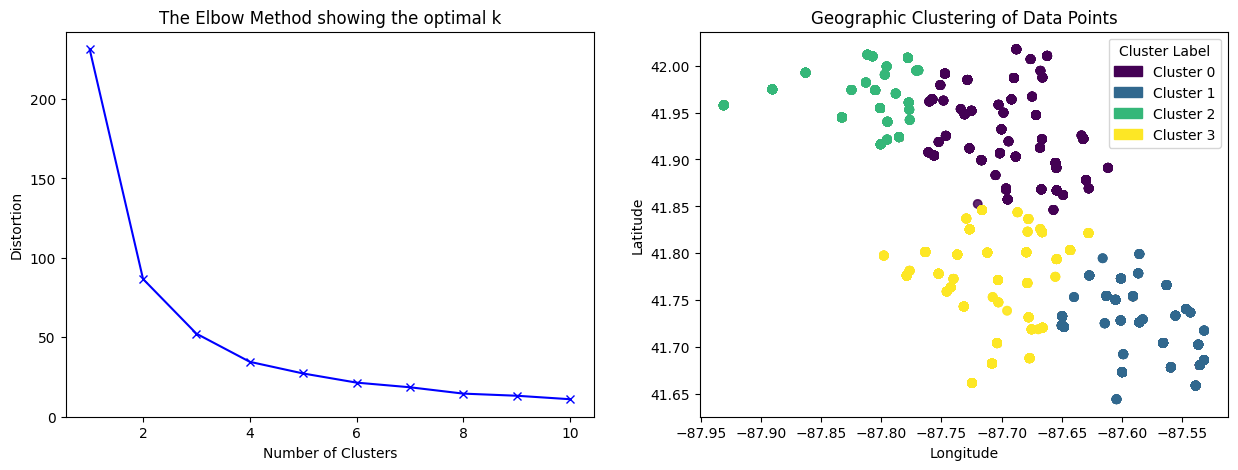


Train Data:
        Date  Species  Block  Trap  Latitude  Longitude  AddressAccuracy  NumMosquitos  WnvPresent  Day_of_Year  Week_of_Year  Month  Day_of_Month  Day_of_Week  Location_Cluster  mosquito_proportion  wnv_case_proportion  wnv_case_proportion_alt
0 2007-05-29        2     41     1     41.95     -87.80                9             1           0          149            22      5            29            1                 2                 0.03                 0.00                     0.10
1 2007-05-29        3     41     1     41.95     -87.80                9             1           0          149            22      5            29            1                 2                 0.03                 0.00                     0.10
2 2007-05-29        3     62     6     41.99     -87.77                9             1           0          149            22      5            29            1                 2                 0.00                 0.00                     0.00
3 2007-

In [27]:
#################################################
## CLEAN TRAIN & TEST DATA
#################################################

# Create copies of the DataFrames
train_clean = train.copy()
test_clean = test.copy()

# Convert 'Date' columns to datetime
train_clean['Date'] = pd.to_datetime(train_clean['Date'])
test_clean['Date'] = pd.to_datetime(test_clean['Date'])

# Train and test have some Trap and Species categories that dont overlap.

common_species = set(train_clean['Species']).intersection(set(test_clean['Species']))
common_traps = set(train_clean['Trap']).intersection(set(test_clean['Trap']))

train_clean = train_clean[train_clean['Species'].isin(common_species) & train_clean['Trap'].isin(common_traps)]
test_clean = test_clean[test_clean['Species'].isin(common_species) & test_clean['Trap'].isin(common_traps)]

# Encoding categorical data in training set and storing mappings
train_clean['Species'] = pd.Categorical(train_clean['Species'])
species_mapping = dict(enumerate(train_clean['Species'].cat.categories))
train_clean['Species'] = train_clean['Species'].cat.codes

test_clean['Species'] = pd.Categorical(test_clean['Species'], categories=species_mapping.values())
test_clean['Species'] = test_clean['Species'].cat.codes

train_clean['Trap'] = pd.Categorical(train_clean['Trap'])
trap_mapping = dict(enumerate(train_clean['Trap'].cat.categories))
train_clean['Trap'] = train_clean['Trap'].cat.codes

test_clean['Trap'] = pd.Categorical(test_clean['Trap'], categories=trap_mapping.values())
test_clean['Trap'] = test_clean['Trap'].cat.codes

# Day of the year is likely important and more granular than month 
train_clean['Day_of_Year'] = train_clean['Date'].dt.dayofyear
train_clean['Week_of_Year'] = train_clean['Date'].dt.isocalendar().week
train_clean['Month'] = train_clean['Date'].dt.month
train_clean['Day_of_Month'] = train_clean['Date'].dt.day
train_clean['Day_of_Week'] = train_clean['Date'].dt.dayofweek

test_clean['Day_of_Year'] = test_clean['Date'].dt.dayofyear
test_clean['Week_of_Year'] = test_clean['Date'].dt.isocalendar().week
test_clean['Month'] = test_clean['Date'].dt.month
test_clean['Day_of_Month'] = test_clean['Date'].dt.day
test_clean['Day_of_Week'] = test_clean['Date'].dt.dayofweek

# Dropping the Address and Street as Trap, Latitude and Longitude are enough
train_clean.drop(['Address', 'Street', 'AddressNumberAndStreet'], axis=1, inplace=True)
test_clean.drop(['Address', 'Street', 'AddressNumberAndStreet', 'Id'], axis=1, inplace=True)

# Cluster the coordinates using K-means clustering. First use the Elbow Method for choosing the right number of clusters (k)
coords_train = train_clean[['Latitude', 'Longitude']]
distortions = []
K = range(1, 11) 
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(coords_train)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
# plt.show()

kmeans = KMeans(n_clusters=4) # 4 was best, found using the Elbow Method above
train_clean['Location_Cluster'] = kmeans.fit_predict(coords_train)

coords_test = test_clean[['Latitude', 'Longitude']]
test_clean['Location_Cluster'] = kmeans.predict(coords_test)

plt.subplot(1,2,2)
scatter = plt.scatter(train_clean['Longitude'], train_clean['Latitude'],
                      c=train_clean['Location_Cluster'], cmap='viridis', alpha=0.6)
colors = plt.cm.viridis(np.linspace(0, 1, 4))  # Get the colormap colors
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(4)]
plt.legend(handles=patches, title='Cluster Label')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Clustering of Data Points')
plt.show()

# Aggregate data by 'Trap'
trap_stats = train_clean.groupby('Trap').agg(
    total_mosquitos=pd.NamedAgg(column='NumMosquitos', aggfunc='sum'),
    total_wnv_cases=pd.NamedAgg(column='WnvPresent', aggfunc='sum')
)
# Percentage of mosquitoes caught in each trap / total caught mosquitoes, e.g. 10% of all mosquitos were caught in Trap 1
trap_stats['mosquito_proportion'] = trap_stats['total_mosquitos'] / trap_stats['total_mosquitos'].sum()
# Percentage of WNV cases in each trap / total caught mosquitoes in each trap, e.g. 5% of mosquitos in Trap 1 tested positive for WNV
trap_stats['wnv_case_proportion'] = trap_stats['total_wnv_cases'] / trap_stats['total_mosquitos']
# Percentage of times WNV was recorded / number of times each trap was recorded, e.g. Trap 1 had at least one positive WNV case 50% of the times it was checked.
trap_stats['wnv_case_proportion_alt'] = train_clean.groupby('Trap')['WnvPresent'].apply(lambda x: x.sum() / len(x))
# Reset index to make 'Trap' a column again for mapping
trap_stats.reset_index(inplace=True)
# Create mappings for each feature
mosquito_proportion_map = dict(zip(trap_stats['Trap'], trap_stats['mosquito_proportion']))
wnv_case_proportion_map = dict(zip(trap_stats['Trap'], trap_stats['wnv_case_proportion']))
wnv_case_proportion_alt_map = dict(zip(trap_stats['Trap'], trap_stats['wnv_case_proportion_alt']))
# Apply mappings to original DataFrame
train_clean['mosquito_proportion'] = train_clean['Trap'].map(mosquito_proportion_map)
train_clean['wnv_case_proportion'] = train_clean['Trap'].map(wnv_case_proportion_map)
train_clean['wnv_case_proportion_alt'] = train_clean['Trap'].map(wnv_case_proportion_alt_map)
# Apply mappings to the test DataFrame
test_clean['mosquito_proportion'] = test_clean['Trap'].map(mosquito_proportion_map).fillna(0)  # Assuming 0 as default for unseen traps
test_clean['wnv_case_proportion'] = test_clean['Trap'].map(wnv_case_proportion_map).fillna(0)  # Assuming 0 as default for unseen traps
test_clean['wnv_case_proportion_alt'] = test_clean['Trap'].map(wnv_case_proportion_alt_map).fillna(0)  # Assuming 0 as default for unseen traps

print("\nTrain Data:")
print(train_clean.head())

print("\nTest Data:")
print(test_clean.head())

train_summary = generate_data_summary(train_clean)
test_summary = generate_data_summary(test_clean)

print("\nTrain Data Summary:")
print(train_summary)

print("\nTest Data Summary:")
print(test_summary)

# Clean Weather Data
Handle missing data, drop unnecessary features, feature engineering, e.g. rolling mean and 1 day lag.

In [28]:
#################################################
## CLEAN WEATHER DATA
#################################################

weather_clean = weather.copy()
weather_clean['Date'] = pd.to_datetime(weather_clean['Date'])

### DEAL WITH NON-NUMERIC VALUES IN NUMERIC COLUMNS ###
# Make M or - a repeat of the value above. T represents trace amounts of precipitation in "PrecipTotal" so make 0.001
weather_clean.replace({'M': pd.NA, '-': pd.NA, '  T': '0.001'}, inplace=True)

# Fill 'M' and '-' in specific columns with the value from the previous row (same day, other station)
weather_clean[weather_numeric_cols] = weather_clean[weather_numeric_cols].ffill()

try:
    # Convert all numerical columns to float for averaging later, raises an error if conversion fails. Alt. errors='coerce' will convert non-convertible values to NaN
    weather_clean[weather_numeric_cols] = weather_clean[weather_numeric_cols].apply(pd.to_numeric, errors='raise')
    print("Conversion successful.")
except ValueError as e:
    print(f"Weather df conversion failed: {e}")
    print(weather_clean.head())

### REMOVE UNHELPFUL COLUMNS ###
# Remove the 'Water1' column as it is always 'M' and thus useless
weather_clean.drop(columns=['Water1'], inplace=True)

# We'll average the data from the two stations so drop 'Station'
weather_clean.drop(columns=['Station'], inplace=True)

# CodeSum weather condition information is likely captured by other measurable features (temp, precipitation, humidity, and wind)
weather_clean.drop(columns=['CodeSum'], inplace=True)

# Depthis always zero
weather_clean.drop(columns=['Depth'], inplace=True)

# Group by Date and take the mean of the numerical columns to combine the two station rows
weather_grouped = weather_clean.groupby('Date').mean().reset_index()

### ADD FEATURES: ROLLING AVERAGES ###
# Most species have an average development time from egg to larva of about 7 to 10 days.
# A 10-day window was chosen to capture the entire development cycle for the majority of the species.
# May also test 7-day window as 10-day might miss critical thresholds that influence development rates
# Rolling averages were added for 
#   - Tmax, Tmin, Tavg: affects mosquito metabolism, behavior, development cycle.
#   - DewPoint and WetBulb: moisture and humidity affect mosquitoes survival and egg hatching
#   - PrecipTotal: impacts the availability of breeding sites 
#   - ResultSpeed, ResultDir, AvgSpeed: wind speed and direction affect mosquito flight and dispersal patterns
window_days = 7
feature_cols = ["Tmax","Tmin","Tavg","DewPoint","WetBulb","PrecipTotal","StnPressure","ResultSpeed","ResultDir","AvgSpeed"]

# Assuming 'Date' is a datetime column
weather_grouped['Year'] = weather_grouped['Date'].dt.year
weather_grouped['Month'] = weather_grouped['Date'].dt.month

# Create a mask for the season (May to October)
weather_grouped['In_Season'] = weather_grouped['Month'].between(5, 10)

for feat in feature_cols:
    # 1-day lag of 'Tmax'
    weather_grouped[f'{feat}_lag1'] = weather_grouped[feat].shift(1)
    weather_grouped.loc[0, f'{feat}_lag1'] = weather_grouped.loc[0, feat]

    # Calculate rolling average only within the same season
    weather_grouped[f'{feat}_{window_days}day_avg'] = weather_grouped.groupby(['Year', 'In_Season'])[feat].rolling(window=window_days, min_periods=window_days).mean().reset_index(level=[0,1], drop=True)

    # Fill NaN values with the mean of the first full window for each group
    weather_grouped[f'{feat}_{window_days}day_avg'] = weather_grouped.groupby(['Year', 'In_Season'])[f'{feat}_{window_days}day_avg'].transform(lambda x: x.ffill().bfill())

# Filter for one particular year for clarity in visualization
example_year = weather_grouped[weather_grouped['Year'] == 2007]

# Re-check the data types after conversions
weather_grouped_summary = generate_data_summary(weather_grouped)

print("\nCleaned Weather Data Summary:")
print(weather_grouped_summary)

Conversion successful.

Cleaned Weather Data Summary:
                               Dtype  Missing Values  Unique Values    count                 mean   std                  min                  max         First Row
AvgSpeed                     float64               0            357 1,472.00                 8.58  3.11                 2.00                23.85  9.39999999999...
AvgSpeed_7day_avg            float64               0            855 1,472.00                 8.56  1.63                 4.54                14.71  11.8071428571...
AvgSpeed_lag1                float64               0            356 1,472.00                 8.57  3.09                 2.00                23.85  9.39999999999...
Cool                         float64               0             50 1,472.00                 5.64  6.06                 0.00                28.50               2.5
Date                  datetime64[ns]               0           1472 1,472.00  2011-01-30 06:00:00   NaN  2007-05-01 00:00:00  

# Merge Cleaned Data
Merge the cleaned weather dataset into the train and test datasets.

In [29]:
# Find dates in train_clean not in weather_clean
dates_in_train = set(train_clean['Date'])
dates_in_weather = set(weather_grouped['Date'])

missing_dates = dates_in_train - dates_in_weather
print(f"Dates in train without weather data: {missing_dates}")

# Merge train_clean and test_clean with weather_clean
train_weather = pd.merge(train_clean, weather_grouped, how='left', on='Date', indicator=True)
test_weather = pd.merge(test_clean, weather_grouped, how='left', on='Date', indicator=True)

# Check for rows that don't have a match in combined_weather
no_match = train_weather[train_weather['_merge'] == 'left_only']
print("\nTrain dates with no corresponding weather data:", no_match['Date'].unique())
no_match = test_weather[test_weather['_merge'] == 'left_only']
print("\nTest dates with no corresponding weather data:", no_match['Date'].unique())

# Drop the unwanted columns
train_weather.drop('Month_y', axis=1, inplace=True)
test_weather.drop('Month_y', axis=1, inplace=True)

train_weather.drop('_merge', axis=1, inplace=True)
test_weather.drop('_merge', axis=1, inplace=True)

train_weather.drop('In_Season', axis=1, inplace=True)
test_weather.drop('In_Season', axis=1, inplace=True)

# Optionally rename the kept columns to remove suffixes
train_weather.rename(columns={'Month_x': 'Month'}, inplace=True)
test_weather.rename(columns={'Month_x': 'Month'}, inplace=True)

print("\nTrain Data:")
print(train_weather.head())

print("\nTest Data:")
print(test_weather.head())

# Re-check the data types after conversions
test_weather_summary = generate_data_summary(test_weather)

print("\nCleaned Weather Data Summary:")
print(test_weather_summary)

Dates in train without weather data: set()

Train dates with no corresponding weather data: <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]

Test dates with no corresponding weather data: <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]

Train Data:
        Date  Species  Block  Trap  Latitude  Longitude  AddressAccuracy  NumMosquitos  WnvPresent  Day_of_Year  Week_of_Year  Month  Day_of_Month  Day_of_Week  Location_Cluster  mosquito_proportion  wnv_case_proportion  wnv_case_proportion_alt  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  Cool  Sunrise   Sunset  SnowFall  PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  Year  Tmax_lag1  Tmax_7day_avg  Tmin_lag1  Tmin_7day_avg  Tavg_lag1  Tavg_7day_avg  DewPoint_lag1  DewPoint_7day_avg  WetBulb_lag1  WetBulb_7day_avg  PrecipTotal_lag1  PrecipTotal_7day_avg  StnPressure_lag1  StnPressure_7day_avg  ResultSpeed_lag1  ResultSpeed_7day_avg  ResultDir_lag1  ResultDir_7day_avg  AvgSpeed_lag1  AvgSpeed_7day_avg
0 2

# Save Cleaned Data
Save the cleaned training dataset to a Parquet file.

In [30]:
train_weather.to_parquet('/app/data/train_with_weather_cleaned_20240514.parquet', engine='fastparquet')
test_weather.to_parquet('/app/data/test_with_weather_cleaned_20240514.parquet', engine='fastparquet')